In [8]:
from glob import glob
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from skimage.color import rgb2gray

In [9]:
INPUT_DIRECTORY = '../../../../data/zoom_5_60_60_partition/'

In [10]:
TRAIN_TEST_SPLIT_FILE = '../../../../data/train_val_test_split.pkl'
META_DATA_FILE = '../../../../data/tumor_img_meta_info.pkl'

In [11]:
# meta_df[['img_id', 'type']]

In [12]:
meta_df = pd.read_pickle(META_DATA_FILE)
train_test_split_df = pd.read_pickle(TRAIN_TEST_SPLIT_FILE)
meta_df = meta_df.merge(train_test_split_df, on='img_id').copy()

In [13]:
meta_df.head()

,img_id,level_5_img_size,level_5_mask_area,level_dimensions,level_downsamples,mask_img_filename,mask_proportion,slide_img_filename,type
0,001,21123072,11116,"((97792, 221184), (48896, 110592), (24448, 552...","(1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, ...",tumor_001_mask.tif,0.052625,tumor_001.tif,val
1,002,20976384,938,"((97792, 219648), (48896, 109824), (24448, 549...","(1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, ...",tumor_002_mask.tif,0.004472,tumor_002.tif,test
2,005,20976384,2323,"((97792, 219648), (48896, 109824), (24448, 549...","(1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, ...",tumor_005_mask.tif,0.011074,tumor_005.tif,train
3,012,20585216,1115,"((97792, 215552), (48896, 107776), (24448, 538...","(1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, ...",tumor_012_mask.tif,0.005417,tumor_012.tif,val
4,016,21123072,156981,"((97792, 221184), (48896, 110592), (24448, 552...","(1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, ...",tumor_016_mask.tif,0.743173,tumor_016.tif,train


In [14]:
def get_img_files_for_img_id(img_id, 
                             data_type):
    file_prefix = 'tumor_slide_{}_split'.format(img_id)
    file_dir = os.path.join(INPUT_DIRECTORY, data_type, 'slide')
    return glob(os.path.join(file_dir, file_prefix + '*.png'))

def get_matching_mask_for_img_file(img_filepath):
    
    basename = os.path.basename(img_filepath)
    data_type = img_filepath.split('/')[-3]
    
    img_id = basename.split('_')[2]
    
    file_path_components = img_filepath.split('/')
    mask_basename = basename.replace('slide', 'mask').replace('.png', '.npy')
    file_path_components[-2] = 'mask'
    file_path_components[-1] = mask_basename
    return '/'.join(file_path_components)
    

In [15]:
result = []

In [16]:
for idx, row in tqdm(meta_df.iterrows()):
    img_id = row['img_id']
    data_type = row['type']
    img_file_paths = get_img_files_for_img_id(img_id, data_type)
    
    # total_mask_size_for_img = 0
    for img_file_path in img_file_paths:
        img_basename = os.path.basename(img_file_path)
        mask_file_path = get_matching_mask_for_img_file(img_file_path)
        mask_pixel_count = np.load(mask_file_path).sum()
        # total_mask_size_for_img += mask_pixel_count
        label = int(mask_pixel_count > 0)

        result.append({
            'img_id': img_id, 
            'file_name': img_basename,
            'label': label,
            # 'total_mask_size_for_img': int(total_mask_size_for_img)
        })

21it [00:55,  2.65s/it]


In [17]:
result_df = pd.DataFrame(result)

In [ ]:
#temp = result_df.drop_duplicates('img_id').copy()

In [ ]:
#temp = result_df.groupby('img_id')['total_mask_size_for_img'].max().reset_index().merge(meta_df, on='img_id')

In [ ]:
result_df['label'].value_counts()

In [ ]:
# result_df.to_pickle('../../../../data/zoom_5_60_60_partition_labels.pkl')

In [ ]:
img_file_path

In [ ]:
sample_file_path = '../../../../data/zoom_5_60_60_partition/train/slide/tumor_slide_110_split_30_40.png'

In [ ]:
tmp = Image.open(sample_file_path)

In [ ]:
tmp

In [18]:
def calc_non_gray_ratio(image, intensity=0.8):
    im_gray = rgb2gray(image/255)
    im_gray_mask = (im_gray <= intensity)
    return (im_gray_mask.mean())

In [ ]:
tmp

In [19]:
infos = []

In [20]:
for idx, row in tqdm(meta_df.iterrows()):
    img_id = row['img_id']
    data_type = row['type']
    img_file_paths = get_img_files_for_img_id(img_id, data_type)
    
    # total_mask_size_for_img = 0
    for img_file_path in img_file_paths:
        img_basename = os.path.basename(img_file_path)
        img_arr = np.asarray(Image.open(img_file_path))
        
        non_gray_ratio = calc_non_gray_ratio(img_arr, intensity=0.8)
        
        infos.append({
            'img_id': img_id, 
            'file_name': img_basename,
            'non_gray_ratio': non_gray_ratio,
            # 'total_mask_size_for_img': int(total_mask_size_for_img)
        })

21it [01:02,  2.99s/it]


In [21]:
temp_df = pd.DataFrame(infos)

In [62]:
temp_df[temp_df['non_gray_ratio'] > 0.4].sort_values('non_gray_ratio').head()

,file_name,img_id,non_gray_ratio
74940,tumor_slide_081_split_9_37.png,081,0.400278
82051,tumor_slide_096_split_11_11.png,096,0.400278
80084,tumor_slide_094_split_10_55.png,094,0.400278
82337,tumor_slide_096_split_15_59.png,096,0.400278
50428,tumor_slide_035_split_114_25.png,035,0.400556


In [24]:
# temp_df.sort_values('non_gray_ratio')

In [63]:
pd.__version__

'0.24.2'

In [ ]:
pd.read_

In [59]:
sample_path = os.path.join(INPUT_DIRECTORY, 'train', 'slide', 'tumor_slide_081_split_9_37.png')

In [60]:
temp = Image.open(sample_path)

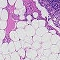

In [61]:
temp

In [ ]:
#temp_df.to_pickle('../../../../data/zoom_5_60_60_partition_grayscale_info.pkl')

In [ ]:
temp_df['non_gray_ratio'].hist(bins=10, range=[0, 0.2])

In [ ]:
TOL = 1e-3

In [ ]:
temp_df[temp_df['non_gray_ratio'] > TOL].shape